In [1]:
import dask.dataframe as dd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#import folium
#import gpxpy.geo
from datetime import datetime
import time
#import seaborn as sns
import os
import math
#import xgboost as xgb
import matplotlib
matplotlib.use('nbagg')
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, train_test_split
#from sklearn.grid_search import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.cluster import MiniBatchKMeans, KMeans
import warnings
warnings.simplefilter('ignore')

In [2]:
data_2016 = dd.read_csv("Downloads/yellow_tripdata_2016-01.csv")

In [3]:
data_2016.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2016-01-01 00:00:00,2016-01-01 00:00:00,2,1.10,-73.990372,40.734695,1,N,-73.981842,40.732407,2,7.5,0.5,0.5,0.0,0.0,0.3,8.8
1,2,2016-01-01 00:00:00,2016-01-01 00:00:00,5,4.90,-73.980782,40.729912,1,N,-73.944473,40.716679,1,18.0,0.5,0.5,0.0,0.0,0.3,19.3
2,2,2016-01-01 00:00:00,2016-01-01 00:00:00,1,10.54,-73.984550,40.679565,1,N,-73.950272,40.788925,1,33.0,0.5,0.5,0.0,0.0,0.3,34.3
3,2,2016-01-01 00:00:00,2016-01-01 00:00:00,1,4.75,-73.993469,40.718990,1,N,-73.962242,40.657333,2,16.5,0.0,0.5,0.0,0.0,0.3,17.3
4,2,2016-01-01 00:00:00,2016-01-01 00:00:00,3,1.76,-73.960625,40.781330,1,N,-73.977264,40.758514,2,8.0,0.0,0.5,0.0,0.0,0.3,8.8


In [4]:
def timeToUnix(t):
    #we have a time in the format "YYYY-MM-DD HH:MM:SS", which is a string
    change = datetime.strptime(t, "%Y-%m-%d %H:%M:%S") #this will convert the String time into datetime format
    t_tuple = change.timetuple() #this will convert the datetime formatted time into structured time
    return time.mktime(t_tuple) + 3600  #this will convert structured time into unix-time.
    #Now why, I have added 3600 in the above unix times. NOW, UNIX TIMESTAMP MEANS HOW MANY SECONDS HAVE ELAPSED SINCE 1 JAN 1970
    #(EPOCH) CALCULATED FROM THE REFERENCE OF GMT. I HAVE MADE THIS PROJECT IN GERMANY WHICH IS 1HR/3600SECS AHEAD OF GMT TIME, 
    #AND HERE "time.mktime()" FUNCTION RETURNS UNIX TIMESTAMP FROM THE REFERENCE OF LOCAL TIME. SO, THEREFORE, IN ORDER TO 
    #COMPENSATE FOR 1HR AHEAD, "time.mktime" SUBTRACTED 3600 SECONDS MEANS 1HR FROM UNIX TIME STAMP IN ORDER TO CATER TO 
    #LOCAL TIME. SO, THEREFORE, IF WE WANT OUR UNIX TIME TO BE EXACTLY EQUAL TO GMT TIME, WE HAVE TO ADD 3600 SECONDS 
    #MEANS 1HR TO UNIX TIME. lET SAY AT 12:00AM ON 1st JAN 1970, TIME ELAPSED AT GMT IS 0, THE TIME ELAPSED IN GERMANY IS 
    #3600SEC. NOW ON 1st JAN 2015, ELASPED SECONDS AT GMT IS 'X', SO THE EQUIVALENT ELAPSED SECONDS IN GERMANY WILL BE X+3600. 
    #NOW "time.mktime()" SUBTRACT THIS 3600 EXTRA IN GERMAN TIME WHICH WE HAVE TO ADD IN ORDER TO MAKE IT EQUAL TO GMT.

def dfWithTripTimes(df):
    startTime = datetime.now()
    duration = df[["tpep_pickup_datetime", "tpep_dropoff_datetime"]].compute()
    pickup_time = [timeToUnix(pkup) for pkup in duration["tpep_pickup_datetime"].values]
    dropoff_time = [timeToUnix(drpof) for drpof in duration["tpep_dropoff_datetime"].values]
#     trip_duration = []
#     for xy in zip(dropoff_time, pickup_time):
#         trip_duration.append(xy[0] - xy[1])
    trip_duration = (np.array(dropoff_time) - np.array(pickup_time))/float(60)  #trip duration in minutes
    
    NewFrame = df[['trip_distance','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','total_amount', 'fare_amount', 'RatecodeID']].compute()
    NewFrame["trip_duration"] = trip_duration
    NewFrame["pickup_time"] = pickup_time
    NewFrame["dropoff_time"] = dropoff_time
    NewFrame["speed"] = (NewFrame["trip_distance"]/NewFrame["trip_duration"])*60  #speed in miles/hr
    
    print("Time taken for creation of dataframe is {}".format(datetime.now() - startTime))
    return NewFrame

In [5]:
data_2016 = data_2016.loc[1:100000]
new_frame = dfWithTripTimes(data_2016)

Time taken for creation of dataframe is 0:02:04.907675


In [6]:
# new_frame.to_csv(r'Desktop\new_frame.csv')
# file now on my computer

In [7]:
#new_frame = dd.read_csv("Desktop/new_frame.csv")

In [8]:
new_frame_cleaned = new_frame[(new_frame.trip_duration>1) & (new_frame.trip_duration<100)]
new_frame_cleaned = new_frame_cleaned[(new_frame_cleaned.speed>0) & (new_frame_cleaned.speed<80)]
new_frame_cleaned = new_frame_cleaned[(new_frame_cleaned.trip_distance>0) & (new_frame_cleaned.trip_distance<23)]
new_frame_cleaned = new_frame_cleaned[(new_frame_cleaned.total_amount>0) & (new_frame_cleaned.total_amount<90.6)]
new_frame_cleaned = new_frame_cleaned[(new_frame_cleaned.fare_amount>0) & (new_frame_cleaned.fare_amount<90.6)]
new_frame_cleaned = new_frame_cleaned[(((new_frame_cleaned.pickup_latitude >= 40.5774) & (new_frame_cleaned.pickup_latitude <= 40.9176)) & ((new_frame_cleaned.pickup_longitude >= -74.15) & (new_frame_cleaned.pickup_longitude <= -73.7004)))]
new_frame_cleaned = new_frame_cleaned[(((new_frame_cleaned.dropoff_latitude >= 40.5774) & (new_frame_cleaned.dropoff_latitude <= 40.9176)) & ((new_frame_cleaned.dropoff_longitude >= -74.15) & (new_frame_cleaned.dropoff_longitude <= -73.7004)))]
new_frame_cleaned = new_frame_cleaned[(new_frame_cleaned.RatecodeID == 1)]
# new_frame_cleaned = new_frame_cleaned.drop(['Unnamed: 0'], axis=1)

In [9]:
new_frame_cleaned.head()

,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,fare_amount,RatecodeID,trip_duration,pickup_time,dropoff_time,speed
5,5.52,-73.980118,40.743050,-73.913490,40.763142,20.3,19.0,1,18.50,1.451596e+09,1.451597e+09,17.902703
6,7.45,-73.994057,40.719990,-73.966362,40.789871,27.3,26.0,1,26.75,1.451596e+09,1.451597e+09,16.710280
7,1.20,-73.979424,40.744614,-73.992035,40.753944,10.3,9.0,1,11.90,1.451596e+09,1.451596e+09,6.050420
8,6.00,-73.947151,40.791046,-73.920769,40.865578,19.3,18.0,1,11.20,1.451596e+09,1.451596e+09,32.142857
9,3.21,-73.998344,40.723896,-73.995850,40.688400,12.8,11.5,1,11.10,1.451596e+09,1.451596e+09,17.351351


In [10]:
# mini batch k-means clustering
# n_cluster and batch_size chosen based on sample code (arbitrary)
# can come back to adjust based on our requirements for better clustering
# or justify why clustering based on this much distance makes sense for taxis 
# for example you won't take a taxi for one/two blocks
coord = new_frame_cleaned[["pickup_latitude", "pickup_longitude"]].values
regions = MiniBatchKMeans(n_clusters = 30, batch_size = 10000).fit(coord)
new_frame_cleaned["pickup_cluster"] = regions.predict(new_frame_cleaned[["pickup_latitude", "pickup_longitude"]])

In [11]:
coord = new_frame_cleaned[["dropoff_latitude", "dropoff_longitude"]].values
regions = MiniBatchKMeans(n_clusters = 30, batch_size = 10000).fit(coord)
new_frame_cleaned["dropoff_cluster"] = regions.predict(new_frame_cleaned[["dropoff_latitude", "dropoff_longitude"]])

In [12]:
x = new_frame_cleaned.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
scaled_new_frame_cleaned = pd.DataFrame(x_scaled, columns = new_frame_cleaned.columns)

In [13]:
scaled_new_frame_cleaned.head()

,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,fare_amount,RatecodeID,trip_duration,pickup_time,dropoff_time,speed,pickup_cluster,dropoff_cluster
0,0.239774,0.313639,0.490550,0.525873,0.546073,0.195044,0.198795,0.0,0.176689,0.000000e+00,0.000391,0.223912,0.758621,0.965517
1,0.323760,0.278729,0.422256,0.408224,0.624661,0.275356,0.283133,0.0,0.260064,0.000000e+00,0.000578,0.208987,0.689655,0.413793
2,0.051784,0.315378,0.495182,0.351097,0.519033,0.080312,0.078313,0.0,0.109988,3.787214e-07,0.000241,0.075555,0.758621,0.000000
3,0.260661,0.396205,0.632695,0.509677,0.847244,0.183570,0.186747,0.0,0.102914,7.574430e-07,0.000226,0.402159,0.655172,0.241379
4,0.139252,0.267990,0.433825,0.342608,0.326327,0.108995,0.108434,0.0,0.101903,7.574430e-07,0.000224,0.217011,0.137931,0.379310


In [14]:
# pickup_time and dropoff_time not 100% sure how they work or what output value they are
# for now we are using it but might want to include hour_of_day
# or create the pickup_time and dropoff_time variables in a different way 

In [15]:
df_x = scaled_new_frame_cleaned.drop(['RatecodeID', 'total_amount', 'fare_amount'], axis=1)
df_y = scaled_new_frame_cleaned.fare_amount

print(df_x.shape)
print(df_y.shape)

(2566655, 11)
(2566655,)


In [16]:
# turn x and y into arrays
y = np.array(df_y)
x = np.array(df_x)

print(x.shape, y.shape)

(2566655, 11) (2566655,)


In [17]:
# x = np.array(x).reshape(-1,1) 
# y = np.array(y).reshape(-1,1) 
# print(x.shape, y.shape)

In [18]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=5)

In [19]:
sgd = SGDRegressor(max_iter=1000, tol=0.01)
sgd.fit(x_train, y_train)

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.01, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [20]:
# predict using training data
y_pred = sgd.predict(x_train)

In [21]:
sgd_rmse1 = np.sqrt(mean_squared_error(y_train, y_pred))
sgd_r21 = r2_score(y_train, y_pred)
mae = mean_absolute_error(y_train, y_pred)
print(sgd_rmse1, sgd_r21, mae)

0.008329831247573576 0.9920135482100562 0.004491568633057


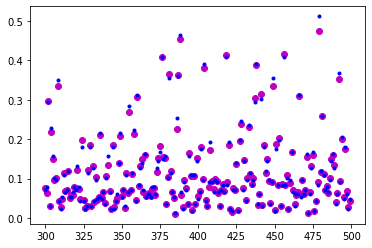

In [25]:
x_idx = np.arange(x_train.shape[0])
plt.plot(x_idx[300:500], y_pred[300:500], 'mo', x_idx[300:500], y_train[300:500], 'b.')
#plt.figure(figsize=(20,20))
plt.show()

In [26]:
y_pred = sgd.predict(x_test)
sgd_rmse1 = np.sqrt(mean_squared_error(y_test, y_pred))
sgd_r21 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(sgd_rmse1, sgd_r21, mae)

0.008292071143913253 0.9920907875400158 0.0044885355516867025


In [ ]:
n_col = df_x.shape[1]
print(n_col)

import keras
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras import optimizers

import keras.backend as K

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

def model() :   #Created a Model using Keras
    model = keras.models.Sequential()
    model.add(Dropout(0.5,input_shape=(n_col,)))
    model.add(BatchNormalization())
    model.add(Dense(512,activation='relu'))#512 neurons in input layer
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(256,activation='relu')) #256 neurons in hidden layer
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(128, activation='relu')) # 1 neuron in output layer
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(1)) #256 neurons in hidden layer
    
    nadam = optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
    adadelta =optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
    adgrad = optimizers.Adagrad(lr=0.001, epsilon=None, decay=0.0)
    rms = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
    
    
    model.compile(optimizer=nadam,loss='mse', metrics=[rmse])
    return model

model = model()
estimator = model.fit(x=x_train,y=y_train, batch_size=1024, epochs=1, 
                    verbose=1, validation_data=(x, y), 
                    shuffle=True)

In [39]:
n_col = df_x.shape[1]
print(n_col)

import keras
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

import keras.backend as K

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

def model() :   #Created a Model using Keras
    model = keras.models.Sequential()
    model.add(Dropout(0.5,input_shape=(n_col,)))
    model.add(BatchNormalization())
    model.add(Dense(1024,activation='relu'))#512 neurons in input layer
    model.add(Dropout(0.5))
    model.add(Dense(512,activation='relu'))#512 neurons in input layer
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(256,activation='relu')) #256 neurons in hidden layer
    model.add(BatchNormalization())
    model.add(Dense(128,activation='relu'))  # 128 neurons in hidden layer
    model.add(BatchNormalization())
    model.add(Dense(64,activation='relu'))   # 64 neurons in hidden layer
    model.add(BatchNormalization())
    model.add(Dense(32,activation='relu'))   # 32 neurons in hidden layer
    model.add(BatchNormalization())
    model.add(Dense(16,activation='relu')) # 16 neurons in hidden layer
    model.add(BatchNormalization())
    model.add(Dense(8,activation='relu')) # 8 neurons in hidden layer
    model.add(BatchNormalization())
    model.add(Dense(1)) # 1 neuron in output layer
    
    nadam = optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
    #adadelta =optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
    #adgrad = optimizers.Adagrad(lr=0.001, epsilon=None, decay=0.0)
    #rms = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
    
    #sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True,clipnorm=0.5)

    model.compile(optimizer=nadam,loss='mse', metrics=[rmse])
    return model


model = model()
estimator = model.fit(x=x_train,y=y_train, batch_size=1024, epochs=1, 
                    verbose=1, validation_data=(x, y), 
                    shuffle=True)

11
Train on 1924991 samples, validate on 2566655 samples
Epoch 1/1
1924991/1924991 [==============================] - 779s 405us/step - loss: 0.0091 - rmse: 0.0488 - val_loss: 0.0053 - val_rmse: 0.0511


In [27]:
#model.summary()

In [47]:
# y_pred = model.predict(x_train)
# x = rmse(y_train, y_pred)
# print(x)

# rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# print(rmse)